In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
import matplotlib.pyplot as plt
%matplotlib notebook
import timeit
start_time=timeit.default_timer()

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()
results_file = './write/pmbc3k.h5ad'

/home/ehamilton/miniconda3/envs/singlecellanalysis/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


scanpy==1.0.4 anndata==0.6.1 numpy==1.14.3 scipy==1.1.0 pandas==0.23.0 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
path = '/home/ehamilton/ProjectSummer2018/GRCh38/treated/filtered_gene_bc_matrices/GRCh38(Ver2)/'
treateddata = sc.read(path + 'matrix.mtx', cache=True).T  # transpose the data
treateddata.var_names = pd.read_csv(path + 'genes.tsv', header=None, sep='\t')[1]
treateddata.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]
print(treateddata.shape)

... reading from cache file ./cache/home-ehamilton-ProjectSummer2018-GRCh38-treated-filtered_gene_bc_matrices-GRCh38(Ver2)-matrix.h5ad
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
(5364, 33694)


In [3]:
treateddata.var_names_make_unique

<bound method AnnData.var_names_make_unique of AnnData object with n_obs × n_vars = 5364 × 33694 >

In [4]:
sc.pp.filter_cells(treateddata, min_genes=200)
sc.pp.filter_genes(treateddata, min_cells=3)

In [5]:
mito_genes = [name for name in treateddata.var_names if name.startswith('MT-')]
treateddata.obs['percent_mito']=np.sum( treateddata[:, mito_genes].X, axis=1).A1 / np.sum(treateddata.X, axis=1).A1
treateddata.obs['n_counts']=treateddata.X.sum(axis=1).A1

/home/ehamilton/miniconda3/envs/singlecellanalysis/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/ehamilton/miniconda3/envs/singlecellanalysis/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


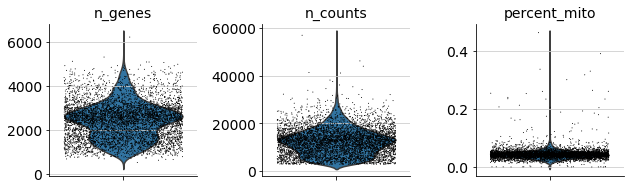

In [6]:
sc.pl.violin(treateddata, ['n_genes','n_counts','percent_mito'], jitter=0.4, multi_panel=True)

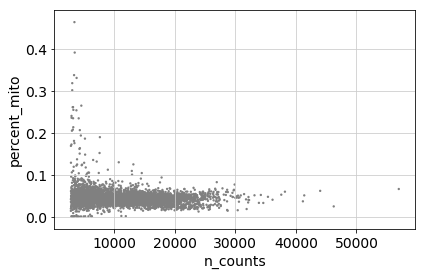

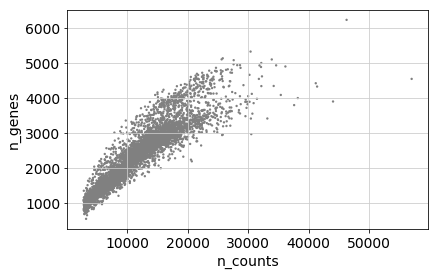

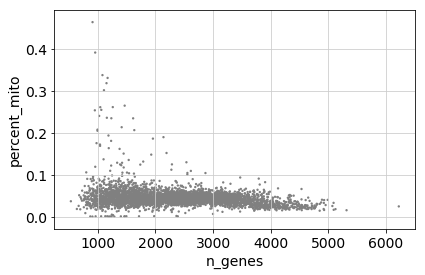

In [7]:
sc.pl.scatter(treateddata, x='n_counts', y='percent_mito')
sc.pl.scatter(treateddata, x='n_counts', y='n_genes')
sc.pl.scatter(treateddata, x='n_genes', y='percent_mito')

In [8]:
treateddata = treateddata[treateddata.obs['n_genes']<5000,:]
treateddata = treateddata[treateddata.obs['percent_mito']<0.1,:]

In [9]:
treateddata.raw = sc.pp.log1p(treateddata, copy=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [10]:
treateddata.var_names_make_unique()

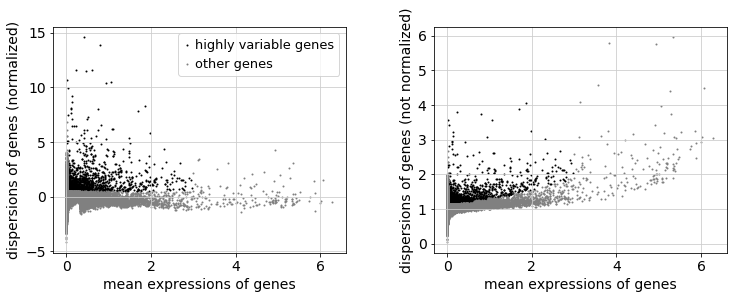

In [11]:
sc.pp.normalize_per_cell(treateddata, counts_per_cell_after=27500)
filter_result=sc.pp.filter_genes_dispersion(treateddata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

In [12]:
treateddata = treateddata[:, filter_result.gene_subset]

In [13]:
sc.pp.log1p(treateddata)

In [14]:
sc.pp.regress_out(treateddata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:11.65)


In [15]:
sc.pp.scale(treateddata, max_value=10)

In [16]:
treateddata.write(results_file)

In [17]:
sc.tl.pca(treateddata)

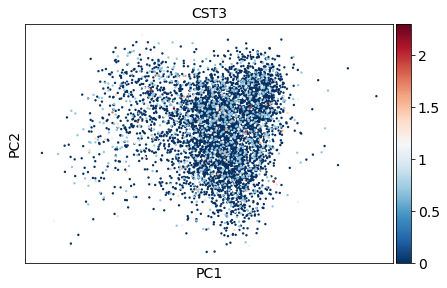

In [18]:
treateddata.obsm['X_pca'] *=-1
sc.pl.pca_scatter(treateddata, color='CST3')

In [19]:
treateddata=sc.read(results_file)

In [20]:
sc.tl.tsne(treateddata, random_state=2, n_pcs=10)
treateddata.write(results_file)

computing tSNE
         Falling back to preprocessing with `sc.pp.pca` and default params.
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:19.95) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


In [21]:
import MulticoreTSNE

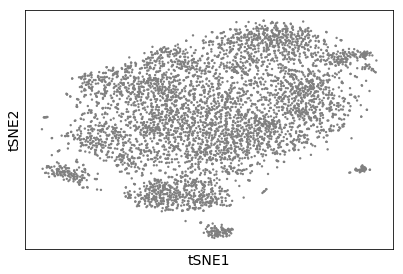

In [22]:
sc.pl.tsne(treateddata)

In [23]:
treateddata=sc.read(results_file)

In [24]:
sc.pp.neighbors(treateddata, n_neighbors=10)

computing neighbors
    using 'X_pca' with n_pcs = 50


/home/ehamilton/miniconda3/envs/singlecellanalysis/lib/python3.6/site-packages/scanpy/neighbors/__init__.py:121: RuntimeWarning: invalid value encountered in sqrt
  distances = np.sqrt(distances)


    finished (0:00:05.61) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [25]:
sc.tl.louvain(treateddata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.47) --> found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


In [26]:
sc.tl.umap(treateddata)

computing UMAP
    finished (0:00:13.71) --> added
    'X_umap', UMAP coordinates (adata.obsm)


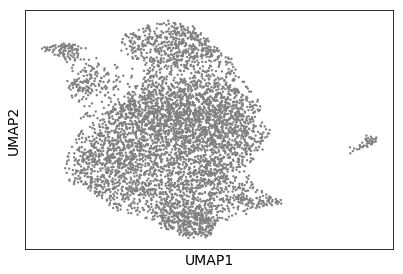

In [27]:
sc.pl.umap(treateddata, use_raw=False)

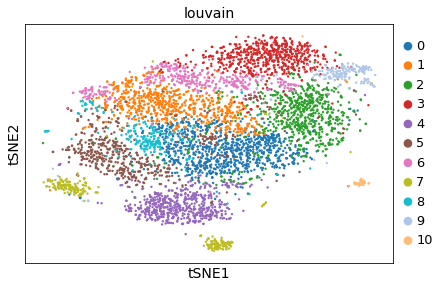

In [28]:
sc.pl.tsne(treateddata, color='louvain')

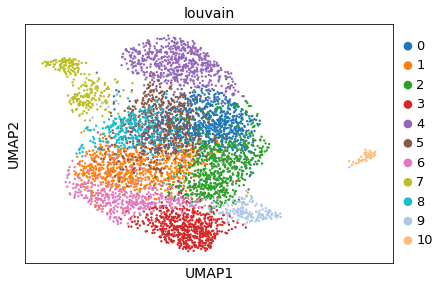

In [29]:
sc.pl.umap(treateddata, color='louvain')

In [30]:
sc.tl.louvain(treateddata, resolution=0.30)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.60) --> found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


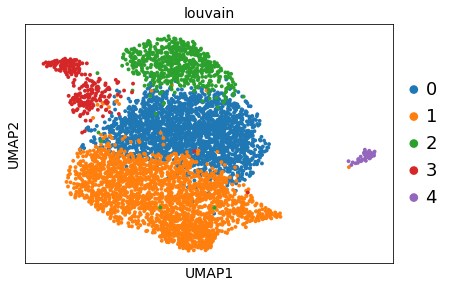

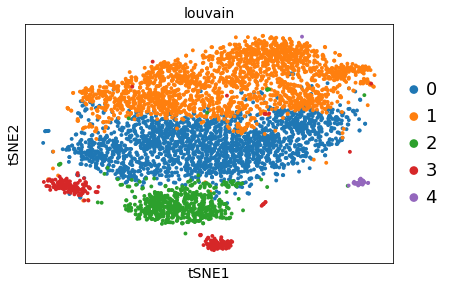

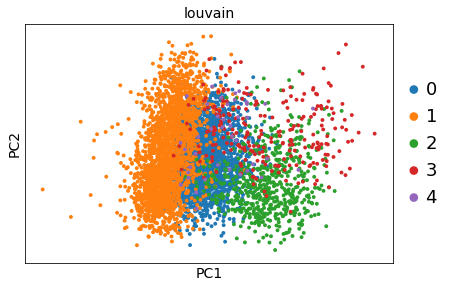

In [31]:
sc.pl.umap(treateddata, color='louvain',size = 60, legend_fontsize = 18)
sc.pl.tsne(treateddata, color='louvain',    size = 60, legend_fontsize = 18)
sc.pl.pca_scatter(treateddata, color='louvain', size = 60, legend_fontsize = 18)

ranking genes
    finished (0:00:02.50) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids


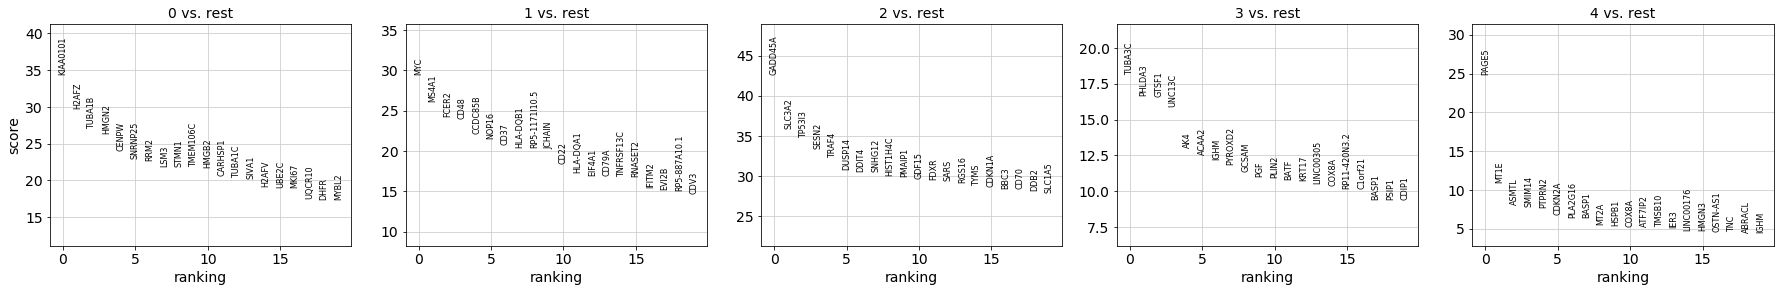

In [32]:
sc.tl.rank_genes_groups(treateddata, 'louvain')
sc.pl.rank_genes_groups(treateddata, n_genes=20,)
treateddata.write(results_file)

In [33]:
treateddata.obs

,n_genes,percent_mito,n_counts,louvain
index,,,,
AAACCTGCAAACCCAT-1,2994,0.045504,10944.0,2
AAACCTGCAGGGAGAG-1,2636,0.036480,11842.0,0
AAACCTGGTAAGAGGA-1,2689,0.030965,12918.0,1
AAACCTGGTCACACGC-1,3063,0.068536,23112.0,1
AAACCTGGTCTAGTCA-1,2455,0.071966,12756.0,0
AAACCTGGTGCAACGA-1,3043,0.049659,16271.0,0
AAACCTGGTGCATCTA-1,4385,0.021528,20299.0,2
AAACCTGGTTGAACTC-1,3016,0.040096,14590.0,0
AAACCTGTCAGCACAT-1,1983,0.035581,9078.0,1


In [34]:
outpath= '/home/ehamilton/ProjectSummer2018/GRCh38/'
outfile = outpath + 'OBS23232323.csv'
treateddata.obs.to_csv(outfile, sep='\t')

In [35]:
treateddata.obs['louvain'].cat.categories = ['KIAA0101','MYC','GADD45A','TUBA3C','PAGE5']

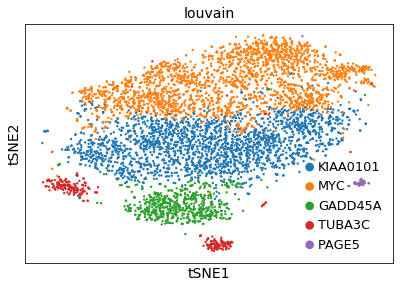

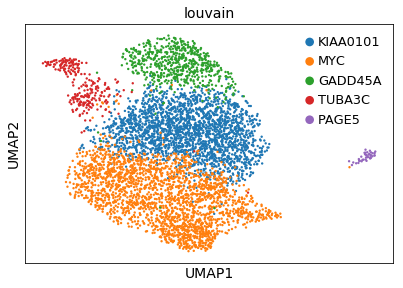

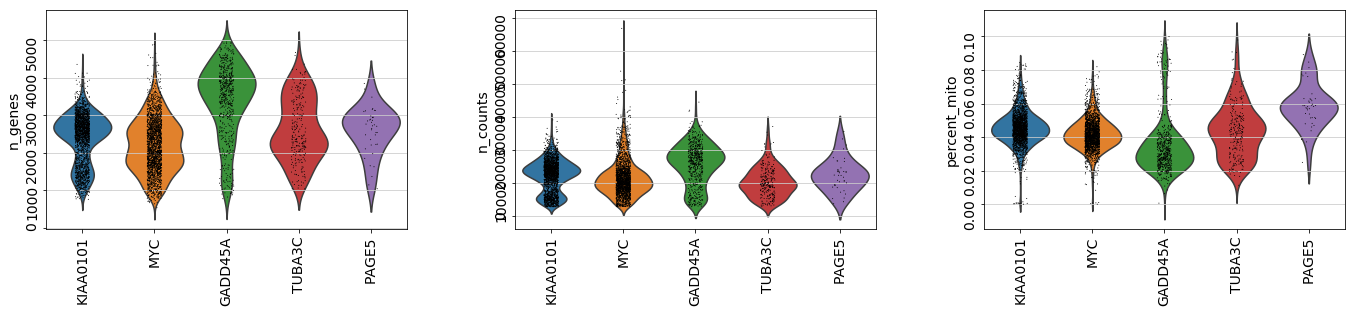

In [36]:
sc.pl.tsne(treateddata, color='louvain', legend_loc='best')
sc.pl.umap(treateddata, color='louvain', legend_loc='best')
sc.pl.violin(treateddata, ['n_genes','n_counts','percent_mito'], groupby='louvain', rotation=90)

In [37]:
treateddata_louvain=pd.DataFrame(treateddata.uns['rank_genes_groups']['names']).head(50)
treateddata_louvain

,0,1,2,3,4
0,KIAA0101,MYC,GADD45A,TUBA3C,PAGE5
1,H2AFZ,MS4A1,SLC3A2,PHLDA3,MT1E
2,TUBA1B,FCER2,TP53I3,GTSF1,ASMTL
3,HMGN2,CD48,SESN2,UNC13C,SMIM14
4,CENPW,CCDC85B,TRAF4,AK4,PTPRN2
5,SNRNP25,NOP16,DUSP14,ACAA2,CDKN2A
6,RRM2,CD37,DDIT4,IGHM,PLA2G16
7,LSM3,HLA-DQB1,SNHG12,PYROXD2,BASP1
8,STMN1,RP5-1171I10.5,HIST1H4C,GCSAM,MT2A
9,TMEM106C,JCHAIN,PMAIP1,PGF,HSPB1


In [38]:
treateddata.obs

,n_genes,percent_mito,n_counts,louvain
index,,,,
AAACCTGCAAACCCAT-1,2994,0.045504,10944.0,GADD45A
AAACCTGCAGGGAGAG-1,2636,0.036480,11842.0,KIAA0101
AAACCTGGTAAGAGGA-1,2689,0.030965,12918.0,MYC
AAACCTGGTCACACGC-1,3063,0.068536,23112.0,MYC
AAACCTGGTCTAGTCA-1,2455,0.071966,12756.0,KIAA0101
AAACCTGGTGCAACGA-1,3043,0.049659,16271.0,KIAA0101
AAACCTGGTGCATCTA-1,4385,0.021528,20299.0,GADD45A
AAACCTGGTTGAACTC-1,3016,0.040096,14590.0,KIAA0101
AAACCTGTCAGCACAT-1,1983,0.035581,9078.0,MYC


In [39]:
cell_cycle_genes = [x.strip() for x in open('/home/ehamilton/ProjectSummer2018/GRCh38/regev_lab_cell_cycle_genes.txt')]

In [40]:
s_genes = cell_cycle_genes[:43]

In [41]:
g2m_genes = cell_cycle_genes[43:]

In [42]:
cell_cycle_genes = [x for x in cell_cycle_genes if x in treateddata.var_names]

In [43]:
sc.tl.score_genes_cell_cycle(treateddata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished (0:00:00.51) --> added
    'S_score', score of gene set (adata.obs)
computing score 'G2M_score'
    finished (0:00:00.74) --> added
    'G2M_score', score of gene set (adata.obs)
-->     'phase', cell cycle phase (adata.obs)


computing UMAP
    finished (0:00:12.72) --> added
    'X_umap', UMAP coordinates (adata.obsm)
... storing 'phase' as categorical


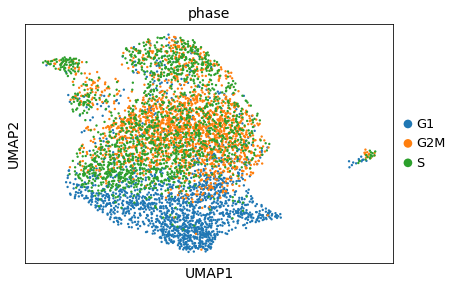

In [44]:
treateddata_cc_genes = treateddata[:, cell_cycle_genes]
sc.tl.umap(treateddata_cc_genes)
sc.pl.umap(treateddata_cc_genes, color='phase')

ranking genes
    finished (0:00:01.54) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids


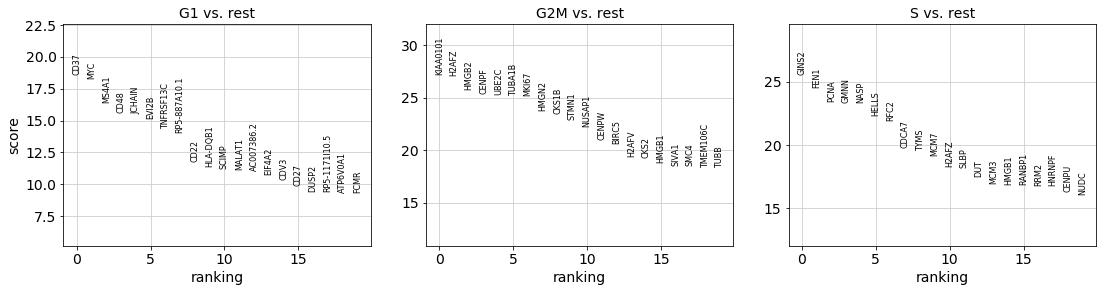

In [45]:
sc.tl.rank_genes_groups(treateddata_cc_genes, 'phase')
sc.pl.rank_genes_groups(treateddata_cc_genes, n_genes=20,)
treateddata_cc_genes.write(results_file)

In [46]:
treateddata_phase = pd.DataFrame(treateddata_cc_genes.uns['rank_genes_groups']['names']).head(50)

In [47]:
set(treateddata_louvain['0']).intersection(treateddata_phase['G1']),set(treateddata_louvain['0']).intersection(treateddata_phase['G2M']),set(treateddata_louvain['0']).intersection(treateddata_phase['S'])

(set(),
 {'CARHSP1',
  'CCDC34',
  'CENPF',
  'CENPW',
  'CKS1B',
  'DHFR',
  'DUT',
  'FTH1',
  'H2AFV',
  'H2AFZ',
  'HMGA1',
  'HMGB1',
  'HMGB2',
  'HMGN1',
  'HMGN2',
  'KIAA0101',
  'LSM3',
  'LSM4',
  'MKI67',
  'MPC2',
  'MYBL2',
  'PTMA',
  'RPA3',
  'RRM2',
  'SIVA1',
  'SNRNP25',
  'STMN1',
  'SVIP',
  'TK1',
  'TMEM106C',
  'TOP2A',
  'TUBA1B',
  'TUBA1C',
  'TUBB',
  'UBE2C',
  'ZDHHC12'},
 {'DUT',
  'H2AFZ',
  'HMGB1',
  'HMGB2',
  'PTMA',
  'RRM2',
  'SIVA1',
  'STMN1',
  'TK1',
  'TUBA1B',
  'TUBB'})

In [48]:
set(treateddata_louvain['1']).intersection(treateddata_phase['G1']),set(treateddata_louvain['1']).intersection(treateddata_phase['G2M']),set(treateddata_louvain['1']).intersection(treateddata_phase['S'])

({'AC007386.2',
  'CCL4',
  'CD22',
  'CD27',
  'CD37',
  'CD48',
  'CDV3',
  'DUSP2',
  'EIF3E',
  'EIF4A2',
  'EVI2B',
  'FCER2',
  'HLA-DMA',
  'HLA-DMB',
  'HLA-DQA1',
  'HLA-DQB1',
  'HLA-DRA',
  'ID2',
  'JCHAIN',
  'MALAT1',
  'MS4A1',
  'MYC',
  'NAALADL2-AS2',
  'RNASET2',
  'RP5-1171I10.5',
  'RP5-887A10.1',
  'SAMSN1',
  'SCIMP',
  'TNFRSF13C'},
 set(),
 set())

In [49]:
set(treateddata_louvain['2']).intersection(treateddata_phase['G1']),set(treateddata_louvain['2']).intersection(treateddata_phase['G2M']),set(treateddata_louvain['2']).intersection(treateddata_phase['S'])

(set(), {'TK1'}, {'CENPU', 'GMNN', 'MCM7', 'SAC3D1', 'TK1', 'TYMS'})

In [50]:
set(treateddata_louvain['3']).intersection(treateddata_phase['G1']),set(treateddata_louvain['3']).intersection(treateddata_phase['G2M']),set(treateddata_louvain['3']).intersection(treateddata_phase['S'])

(set(), {'HMGB1'}, {'HMGB1', 'PSIP1'})

In [51]:
set(treateddata_louvain['4']).intersection(treateddata_phase['G1']),set(treateddata_louvain['4']).intersection(treateddata_phase['G2M']),set(treateddata_louvain['4']).intersection(treateddata_phase['S'])

(set(), set(), set())

In [52]:
len(set(treateddata_louvain['0']).intersection(treateddata_phase['G1'])),len(set(treateddata_louvain['0']).intersection(treateddata_phase['G2M'])),len(set(treateddata_louvain['0']).intersection(treateddata_phase['S']))

(0, 36, 11)

In [53]:
len(set(treateddata_louvain['1']).intersection(treateddata_phase['G1'])),len(set(treateddata_louvain['1']).intersection(treateddata_phase['G2M'])),len(set(treateddata_louvain['1']).intersection(treateddata_phase['S']))

(29, 0, 0)

In [54]:
len(set(treateddata_louvain['2']).intersection(treateddata_phase['G1'])),len(set(treateddata_louvain['2']).intersection(treateddata_phase['G2M'])),len(set(treateddata_louvain['2']).intersection(treateddata_phase['S']))

(0, 1, 6)

In [55]:
len(set(treateddata_louvain['3']).intersection(treateddata_phase['G1'])),len(set(treateddata_louvain['3']).intersection(treateddata_phase['G2M'])),len(set(treateddata_louvain['3']).intersection(treateddata_phase['S']))

(0, 1, 2)

In [56]:
len(set(treateddata_louvain['4']).intersection(treateddata_phase['G1'])),len(set(treateddata_louvain['4']).intersection(treateddata_phase['G2M'])),len(set(treateddata_louvain['4']).intersection(treateddata_phase['S']))

(0, 0, 0)

In [57]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt

In [58]:
N=5
ind = np.arange(N)

In [59]:
Cluster1 = (0, 30, 0, 0, 0)
Cluster2 = (36, 0, 2, 1, 0)
Cluster3 = (11, 0, 6, 3, 0)

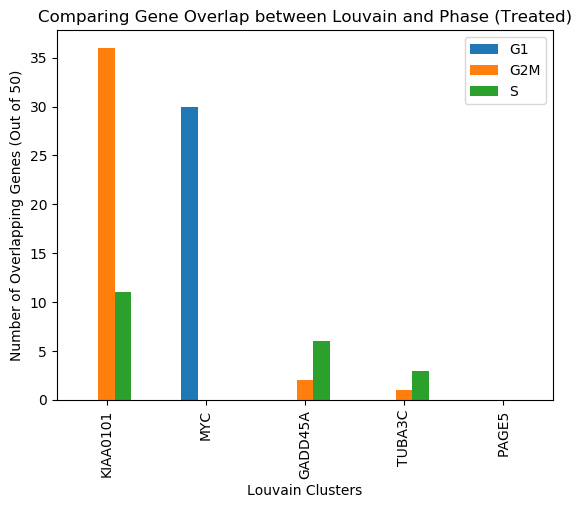

In [60]:
df=pd.DataFrame({'G1':Cluster1, 'G2M':Cluster2, 'S':Cluster3})
df.plot(kind='bar', stacked=False)
plt.ylabel('Number of Overlapping Genes (Out of 50)')
plt.xlabel('Louvain Clusters')
plt.title('Comparing Gene Overlap between Louvain and Phase (Treated)')
plt.xticks(ind, ('KIAA0101','MYC','GADD45A','TUBA3C','PAGE5'))
plt.legend(loc='best')
plt.show()

In [61]:
sc.pp.regress_out(treateddata, ['S_score', 'G2M_score'])
sc.pp.scale(treateddata)

regressing out ['S_score', 'G2M_score']
    finished (0:00:11.23)


In [62]:
treateddata_cc_genes = treateddata[:, cell_cycle_genes]
sc.tl.pca(treateddata_cc_genes)

... storing 'phase' as categorical


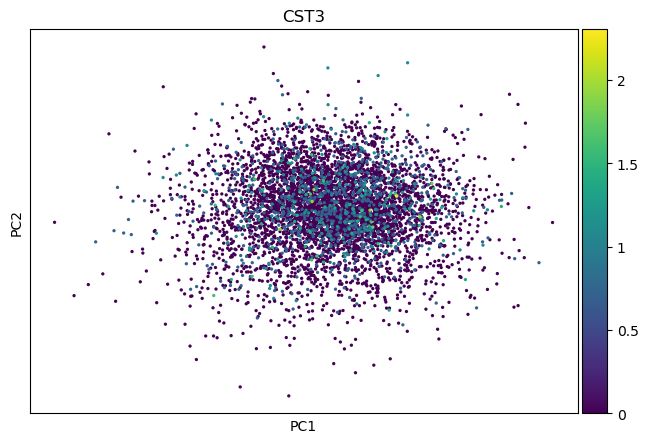

In [63]:
treateddata_cc_genes.obsm['X_pca'] *=-1
sc.pl.pca_scatter(treateddata_cc_genes, color='CST3')

In [64]:
sc.tl.tsne(treateddata_cc_genes, random_state=2, n_pcs=10)
treateddata_cc_genes.write(results_file)

computing tSNE
    using data matrix X directly
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:18.25) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


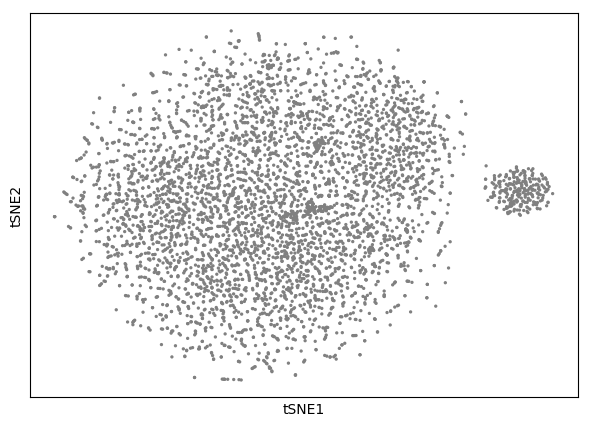

In [65]:
sc.pl.tsne(treateddata_cc_genes)

In [66]:
sc.pp.neighbors(treateddata_cc_genes, n_neighbors=10)

computing neighbors
    initialized `.distances` `.connectivities` 
    using data matrix X directly


/home/ehamilton/miniconda3/envs/singlecellanalysis/lib/python3.6/site-packages/scanpy/neighbors/__init__.py:121: RuntimeWarning: invalid value encountered in sqrt
  distances = np.sqrt(distances)


    finished (0:00:01.68) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [67]:
sc.tl.louvain(treateddata_cc_genes)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.75) --> found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


In [68]:
sc.tl.umap(treateddata_cc_genes)

computing UMAP
    finished (0:00:11.88) --> added
    'X_umap', UMAP coordinates (adata.obsm)


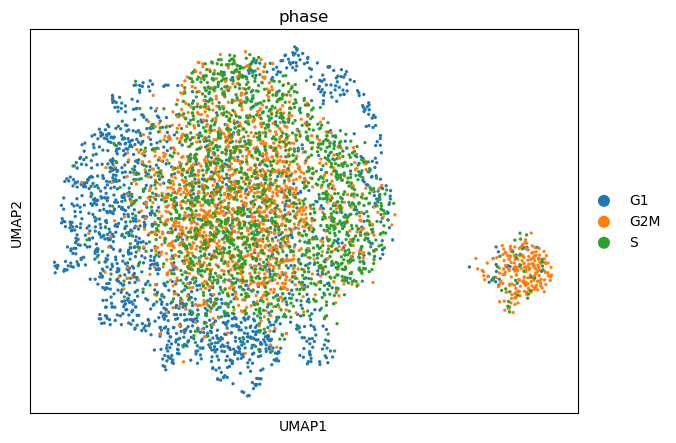

In [69]:
sc.pl.umap(treateddata_cc_genes, color='phase')

In [70]:
path = '/home/ehamilton/ProjectSummer2018/GRCh38/treated/filtered_gene_bc_matrices/GRCh38(Ver2)/'
Untreated = pd.read_csv(path + 'Rank Genes 20 Clusters.csv', sep='\t')

In [71]:
set(treateddata_louvain['0']).intersection(Untreated['HIST1H4C']),set(treateddata_louvain['1']).intersection(Untreated['HIST1H4C']),set(treateddata_louvain['2']).intersection(Untreated['HIST1H4C']),set(treateddata_louvain['3']).intersection(Untreated['HIST1H4C']),set(treateddata_louvain['4']).intersection(Untreated['HIST1H4C'])

({'DUT', 'KIAA0101', 'TK1'},
 {'MIR155HG'},
 {'CDKN1A', 'HIST1H4C', 'TK1'},
 set(),
 set())

In [72]:
set(treateddata_louvain['0']).intersection(Untreated['CDC20']),set(treateddata_louvain['1']).intersection(Untreated['CDC20']),set(treateddata_louvain['2']).intersection(Untreated['CDC20']),set(treateddata_louvain['3']).intersection(Untreated['CDC20']),set(treateddata_louvain['4']).intersection(Untreated['CDC20'])

({'CENPF', 'CKS1B', 'HMGB1', 'HMGB2', 'TUBA1B', 'TUBA1C', 'UBE2C'},
 set(),
 set(),
 {'HMGB1'},
 set())

In [73]:
set(treateddata_louvain['0']).intersection(Untreated['JCHAIN']),set(treateddata_louvain['1']).intersection(Untreated['JCHAIN']),set(treateddata_louvain['2']).intersection(Untreated['JCHAIN']),set(treateddata_louvain['3']).intersection(Untreated['JCHAIN']),set(treateddata_louvain['4']).intersection(Untreated['JCHAIN'])

(set(),
 {'CD27', 'CD37', 'EVI2B', 'JCHAIN', 'MALAT1', 'MS4A1', 'RP5-887A10.1'},
 set(),
 set(),
 set())

In [74]:
set(treateddata_louvain['0']).intersection(Untreated['TUBA3C']),set(treateddata_louvain['1']).intersection(Untreated['TUBA3C']),set(treateddata_louvain['2']).intersection(Untreated['TUBA3C']),set(treateddata_louvain['3']).intersection(Untreated['TUBA3C']),set(treateddata_louvain['4']).intersection(Untreated['TUBA3C'])

(set(),
 set(),
 set(),
 {'ACAA2',
  'AK4',
  'C1orf21',
  'CCDC74A',
  'COX8A',
  'GCSAM',
  'GTSF1',
  'HIST1H1C',
  'IGHM',
  'JAK1',
  'LINC00305',
  'MGST2',
  'PFN2',
  'PLIN2',
  'PYROXD2',
  'RP11-420N3.2',
  'TUBA3C',
  'UNC13C'},
 {'ACAA2', 'COX8A', 'IGHM', 'IGLC2', 'IGLC3', 'UNC13C'})

In [75]:
set(treateddata_louvain['0']).intersection(Untreated['PAGE5']),set(treateddata_louvain['1']).intersection(Untreated['PAGE5']),set(treateddata_louvain['2']).intersection(Untreated['PAGE5']),set(treateddata_louvain['3']).intersection(Untreated['PAGE5']),set(treateddata_louvain['4']).intersection(Untreated['TUBA3C'])

({'TMSB10'},
 set(),
 set(),
 {'BASP1', 'COX8A', 'IGHM', 'INO80C'},
 {'ACAA2', 'COX8A', 'IGHM', 'IGLC2', 'IGLC3', 'UNC13C'})

In [76]:
len(set(treateddata_louvain['0']).intersection(Untreated['HIST1H4C'])),len(set(treateddata_louvain['1']).intersection(Untreated['HIST1H4C'])),len(set(treateddata_louvain['2']).intersection(Untreated['HIST1H4C'])),len(set(treateddata_louvain['3']).intersection(Untreated['HIST1H4C'])),len(set(treateddata_louvain['4']).intersection(Untreated['HIST1H4C']))

(3, 1, 3, 0, 0)

In [77]:
len(set(treateddata_louvain['0']).intersection(Untreated['HIST1H4C'])),len(set(treateddata_louvain['1']).intersection(Untreated['CDC20'])),len(set(treateddata_louvain['2']).intersection(Untreated['CDC20'])),len(set(treateddata_louvain['3']).intersection(Untreated['CDC20'])),len(set(treateddata_louvain['4']).intersection(Untreated['CDC20']))

(3, 0, 0, 1, 0)

In [78]:
len(set(treateddata_louvain['0']).intersection(Untreated['JCHAIN'])),len(set(treateddata_louvain['1']).intersection(Untreated['JCHAIN'])),len(set(treateddata_louvain['2']).intersection(Untreated['JCHAIN'])),len(set(treateddata_louvain['3']).intersection(Untreated['JCHAIN'])),len(set(treateddata_louvain['4']).intersection(Untreated['JCHAIN']))

(0, 7, 0, 0, 0)

In [79]:
len(set(treateddata_louvain['0']).intersection(Untreated['TUBA3C'])),len(set(treateddata_louvain['1']).intersection(Untreated['TUBA3C'])),len(set(treateddata_louvain['2']).intersection(Untreated['TUBA3C'])),len(set(treateddata_louvain['3']).intersection(Untreated['TUBA3C'])),len(set(treateddata_louvain['4']).intersection(Untreated['TUBA3C']))

(0, 0, 0, 18, 6)

In [80]:
len(set(treateddata_louvain['0']).intersection(Untreated['PAGE5'])),len(set(treateddata_louvain['1']).intersection(Untreated['PAGE5'])),len(set(treateddata_louvain['2']).intersection(Untreated['PAGE5'])),len(set(treateddata_louvain['3']).intersection(Untreated['PAGE5'])),len(set(treateddata_louvain['4']).intersection(Untreated['PAGE5']))

(1, 0, 0, 4, 18)

In [81]:
Cluster1 = (3, 3, 0, 0, 1)
Cluster2 = (1, 0, 7, 0, 0)
Cluster3 = (3, 0, 0, 0, 0)
Cluster4 = (0, 1, 0, 18, 4)
Cluster5 = (0, 0, 0, 6, 18)

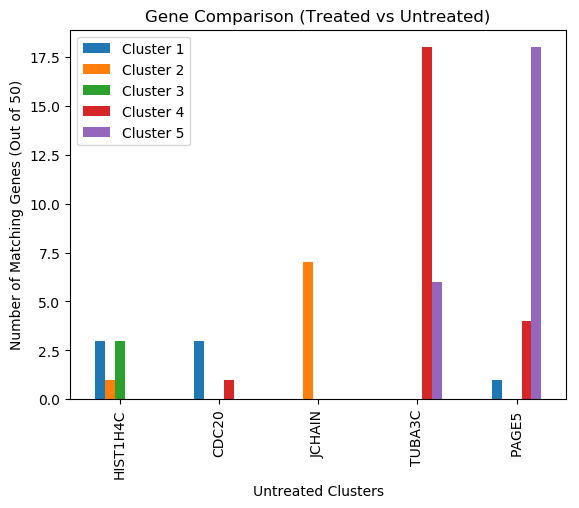

In [82]:
df=pd.DataFrame({'Cluster 1':Cluster1, 'Cluster 2':Cluster2, 'Cluster 3':Cluster3, 'Cluster 4':Cluster4, 'Cluster 5':Cluster5})
df.plot(kind='bar', stacked=False)
plt.ylabel('Number of Matching Genes (Out of 50)')
plt.xlabel('Untreated Clusters')
plt.title('Gene Comparison (Treated vs Untreated)')
plt.xticks(ind, ('HIST1H4C', 'CDC20', 'JCHAIN', 'TUBA3C', 'PAGE5'))
plt.legend(loc='best')
plt.show()

In [83]:
treated.obs

NameError: name 'treated' is not defined